In [1]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.signal import detrend
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('darkgrid')

In [2]:
data = pd.read_csv('../data/processed_files/processed_data.csv')
data['date'] = pd.to_datetime(data['date'])

## Adding some helpful columns to the data

In [3]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
item_cat_order = data['item_category_name'].unique()

data['year'] = data['date'].dt.year
data['month'] = pd.Categorical(data['date'].dt.month_name(), categories=months_order)
data['day'] = data['date'].dt.day
data['week_day'] = pd.Categorical(data['date'].dt.day_name(), categories=day_order)
data['item_cat'] = pd.Categorical(data['item_category_name'], categories=item_cat_order)
data['revenue'] = data['item_cnt_day'] * data['item_price']

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2895398 entries, 0 to 2895397
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        int64         
 6   item_name           object        
 7   item_category_id    int64         
 8   shop_name           object        
 9   item_category_name  object        
 10  year                int32         
 11  month               category      
 12  day                 int32         
 13  week_day            category      
 14  item_cat            category      
 15  revenue             float64       
dtypes: category(3), datetime64[ns](1), float64(2), int32(2), int64(5), object(3)
memory usage: 273.4+ MB


## look at the relations between target and other columns


#### numerical data

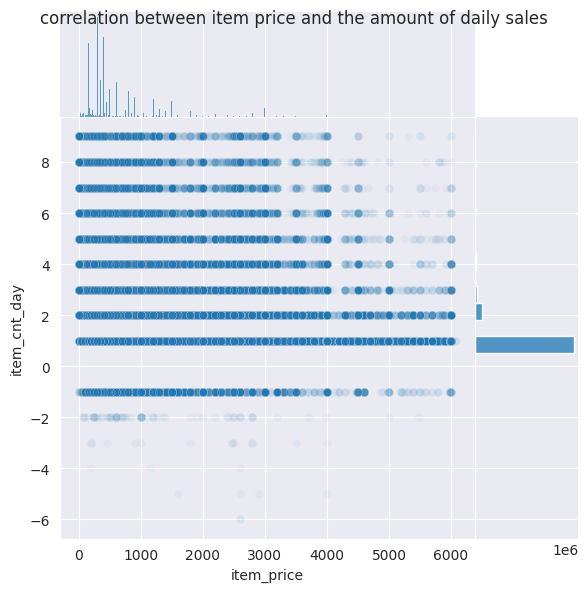

In [5]:
grid = sns.jointplot(data=data[['item_cnt_day', 'item_price']], x='item_price', y='item_cnt_day', space=0, ratio=4, joint_kws={'alpha':0.05})
grid.figure.suptitle('correlation between item price and the amount of daily sales')
plt.show()

# the graph is really bad, but I couldn't find a better way to visualise this

From what we see on the figure, we can colclude that cheaper items are sold (and returned) more often overall, and items are mostly sold once or twice a day

#### categorial data

here I'm trying to see a distibution of the amount of items sold daily with respect to different values of categorial columns

In [22]:
def barplots(df: pd.DataFrame, columns: list[str], target='item_cnt_day', hue: str = None, aggregation: str = 'sum', title: str = None, show_line=False, legend=False):

    figsize = (20, 5*len(columns))
    plt.figure(figsize=figsize)
    if title:
        plt.suptitle(title, fontsize=16)

    for idx, col in enumerate(columns):
        _hue = hue
        data_to_plot = None
        used_cols = [target, col]
        if _hue:
            used_cols.append(_hue)
        if aggregation == 'sum':
            data_to_plot = df[used_cols].groupby(used_cols[1::]).sum()
        elif aggregation == 'mean':
            data_to_plot = df[used_cols].groupby(used_cols[1::]).mean()
        elif aggregation == 'max':
            data_to_plot = df[used_cols].groupby(used_cols[1::]).max()
        plt.subplot(len(columns), 1, idx+1)
        bp = sns.barplot(data_to_plot, x=col, y=target, hue=_hue,
                            palette=sns.color_palette('Set2'), legend=legend)
        if show_line:
            sns.lineplot(data=data_to_plot, x=col, y=target,
                         palette=sns.color_palette('Set2'))
        for item in bp.get_xticklabels():
            item.set_rotation(90)
    plt.subplots_adjust(bottom=0.1,
                        top=0.9,
                        hspace=0.2)
    plt.show()

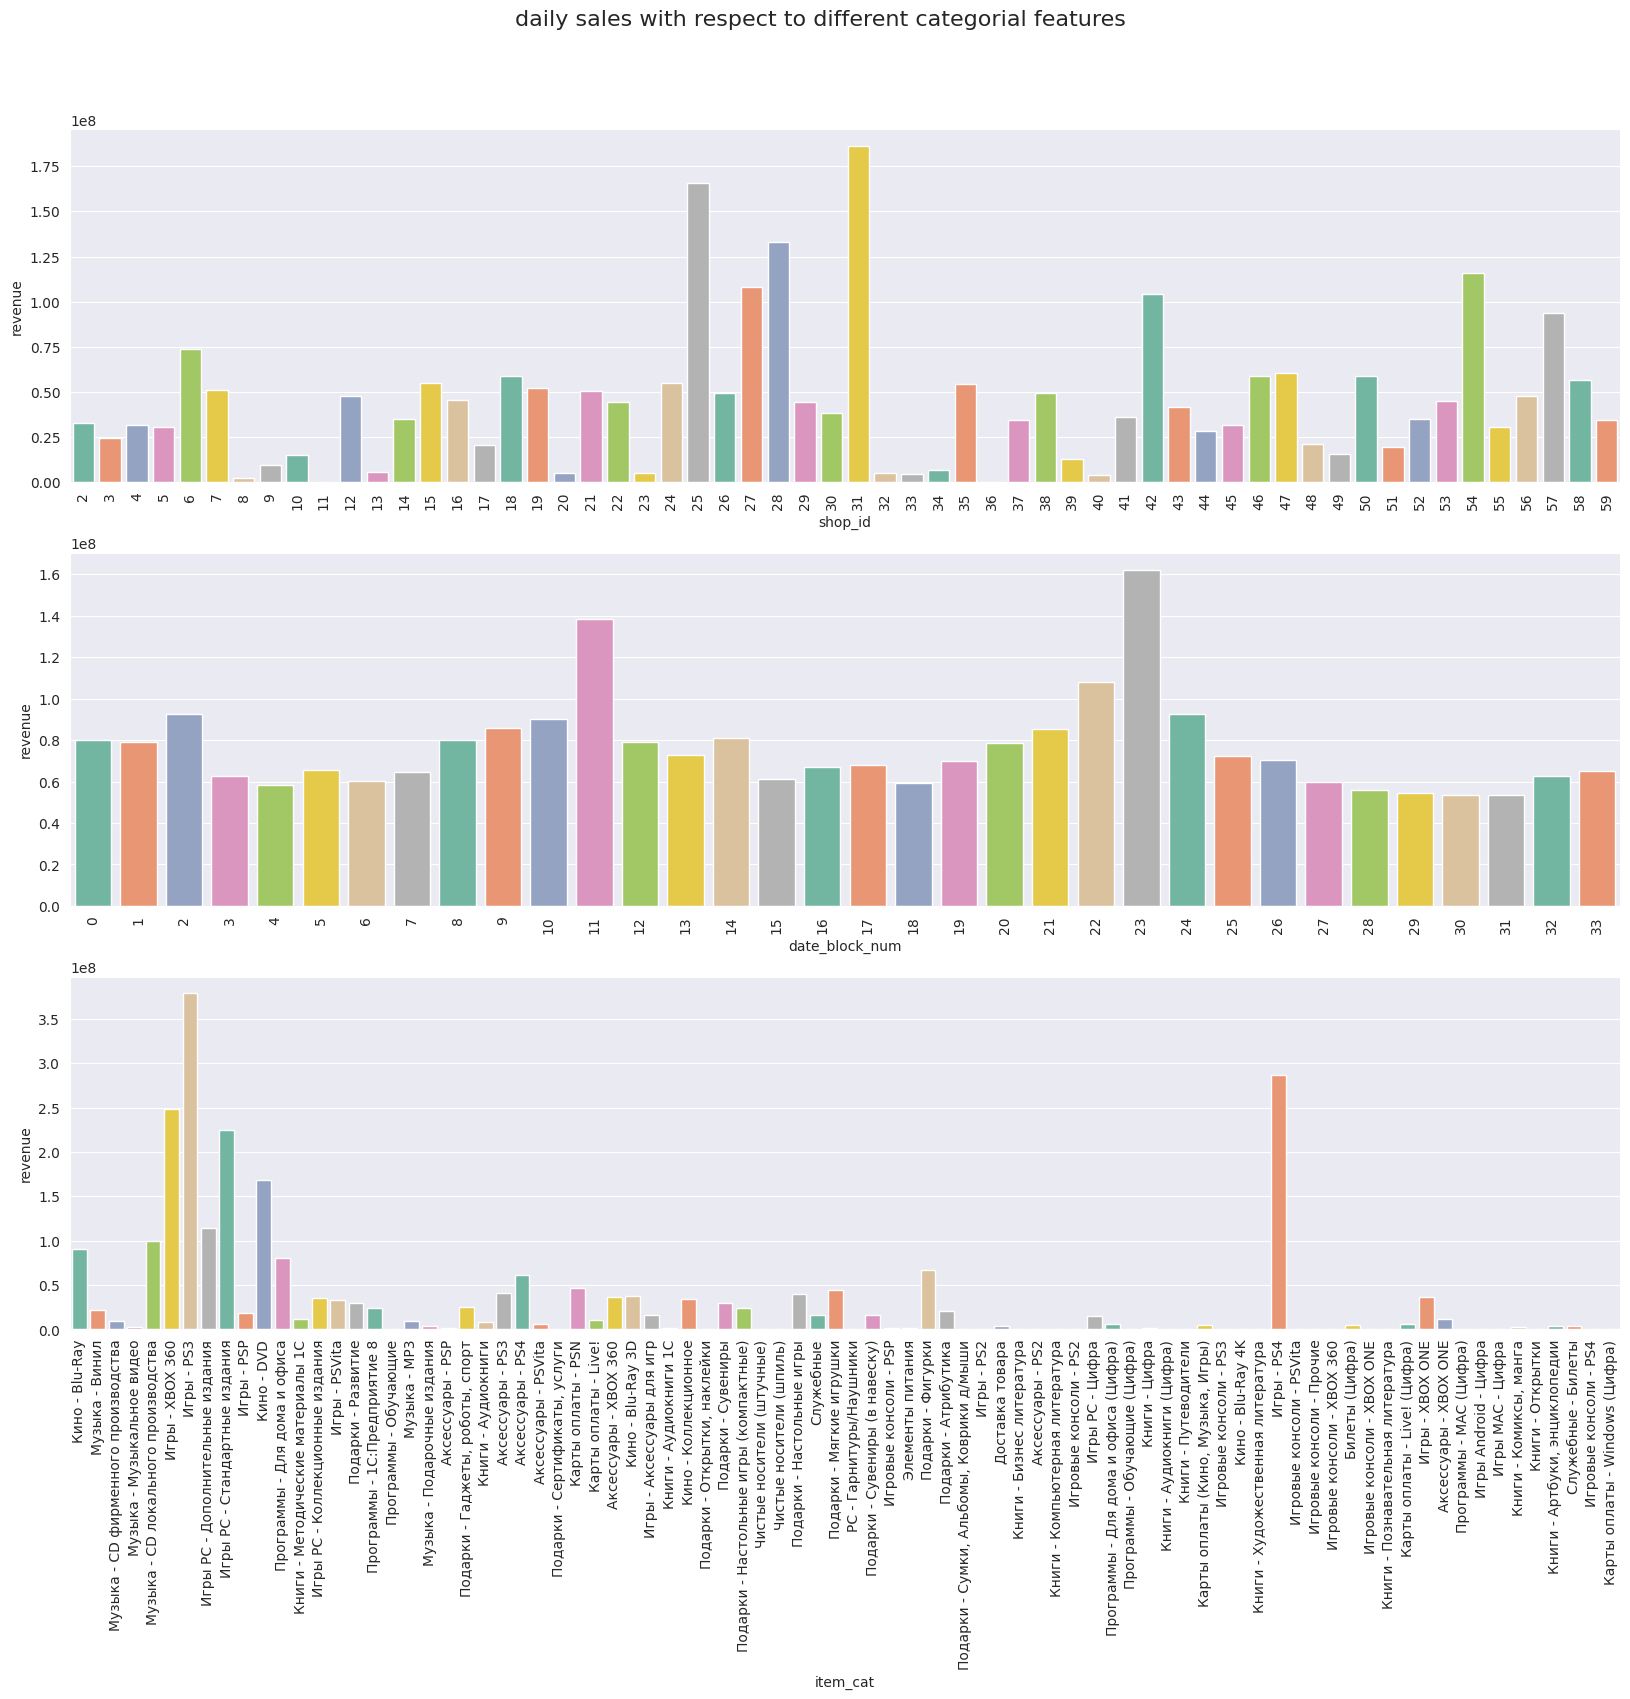

In [25]:
cols = ['shop_id', 'date_block_num', 'item_cat']

barplots(data, cols, title='daily sales with respect to different categorial features', aggregation='sum', target='revenue')

the amount of items sold has a sigificant drop around the 24th month mark, so let's see it as a line as well

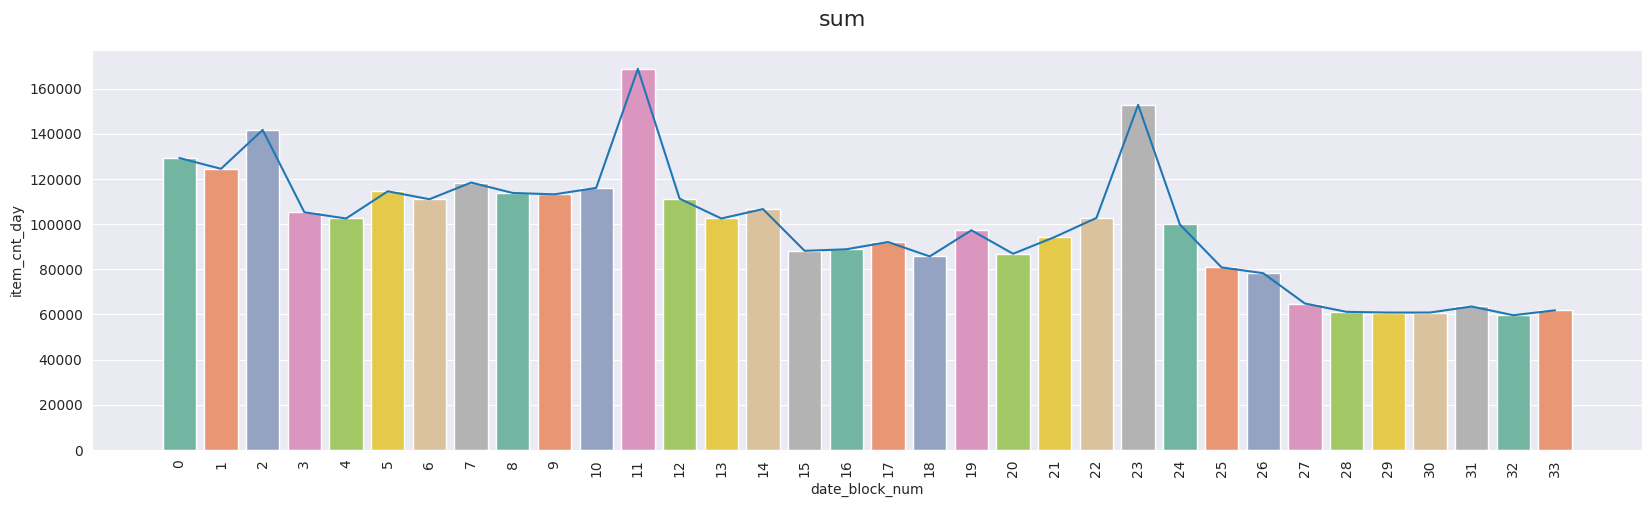

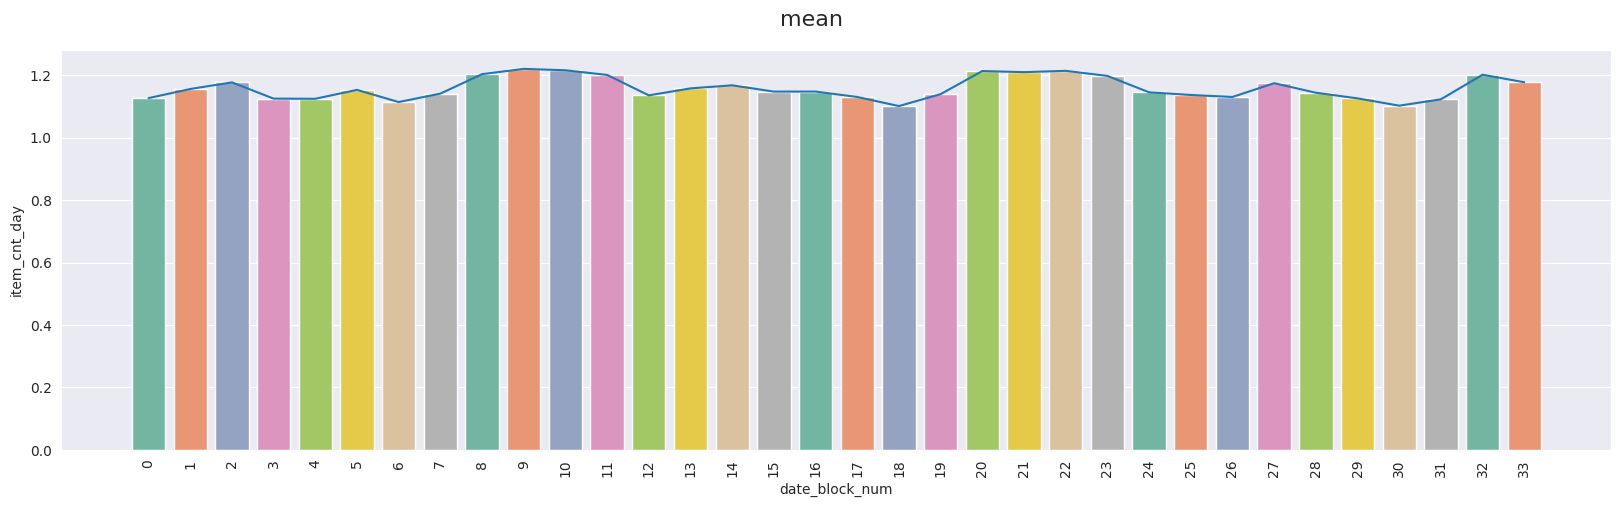

In [8]:
barplots(data, ['date_block_num'], aggregation='sum', show_line=True, title='sum')
barplots(data, ['date_block_num'], aggregation='mean', show_line=True, title='mean')

we can see that the amount of items sold increases every 12 months (which we already saw during DQC) and remains approx. the same during the whole period (though, the overall sales do decrease a little by the end of the period)

at the same time, we can see that the amount of items sold has quite a high variance depending on the category and the shop, so that gives us a hint that those two columns will be an important factor while predicting the future sales.

also, we can see that the overall revenue during the last few months decreased a lot, while mean spiked to its all-time highest value. this probably means that by the end of the period pople started buying more expensive items, and less cheap ones

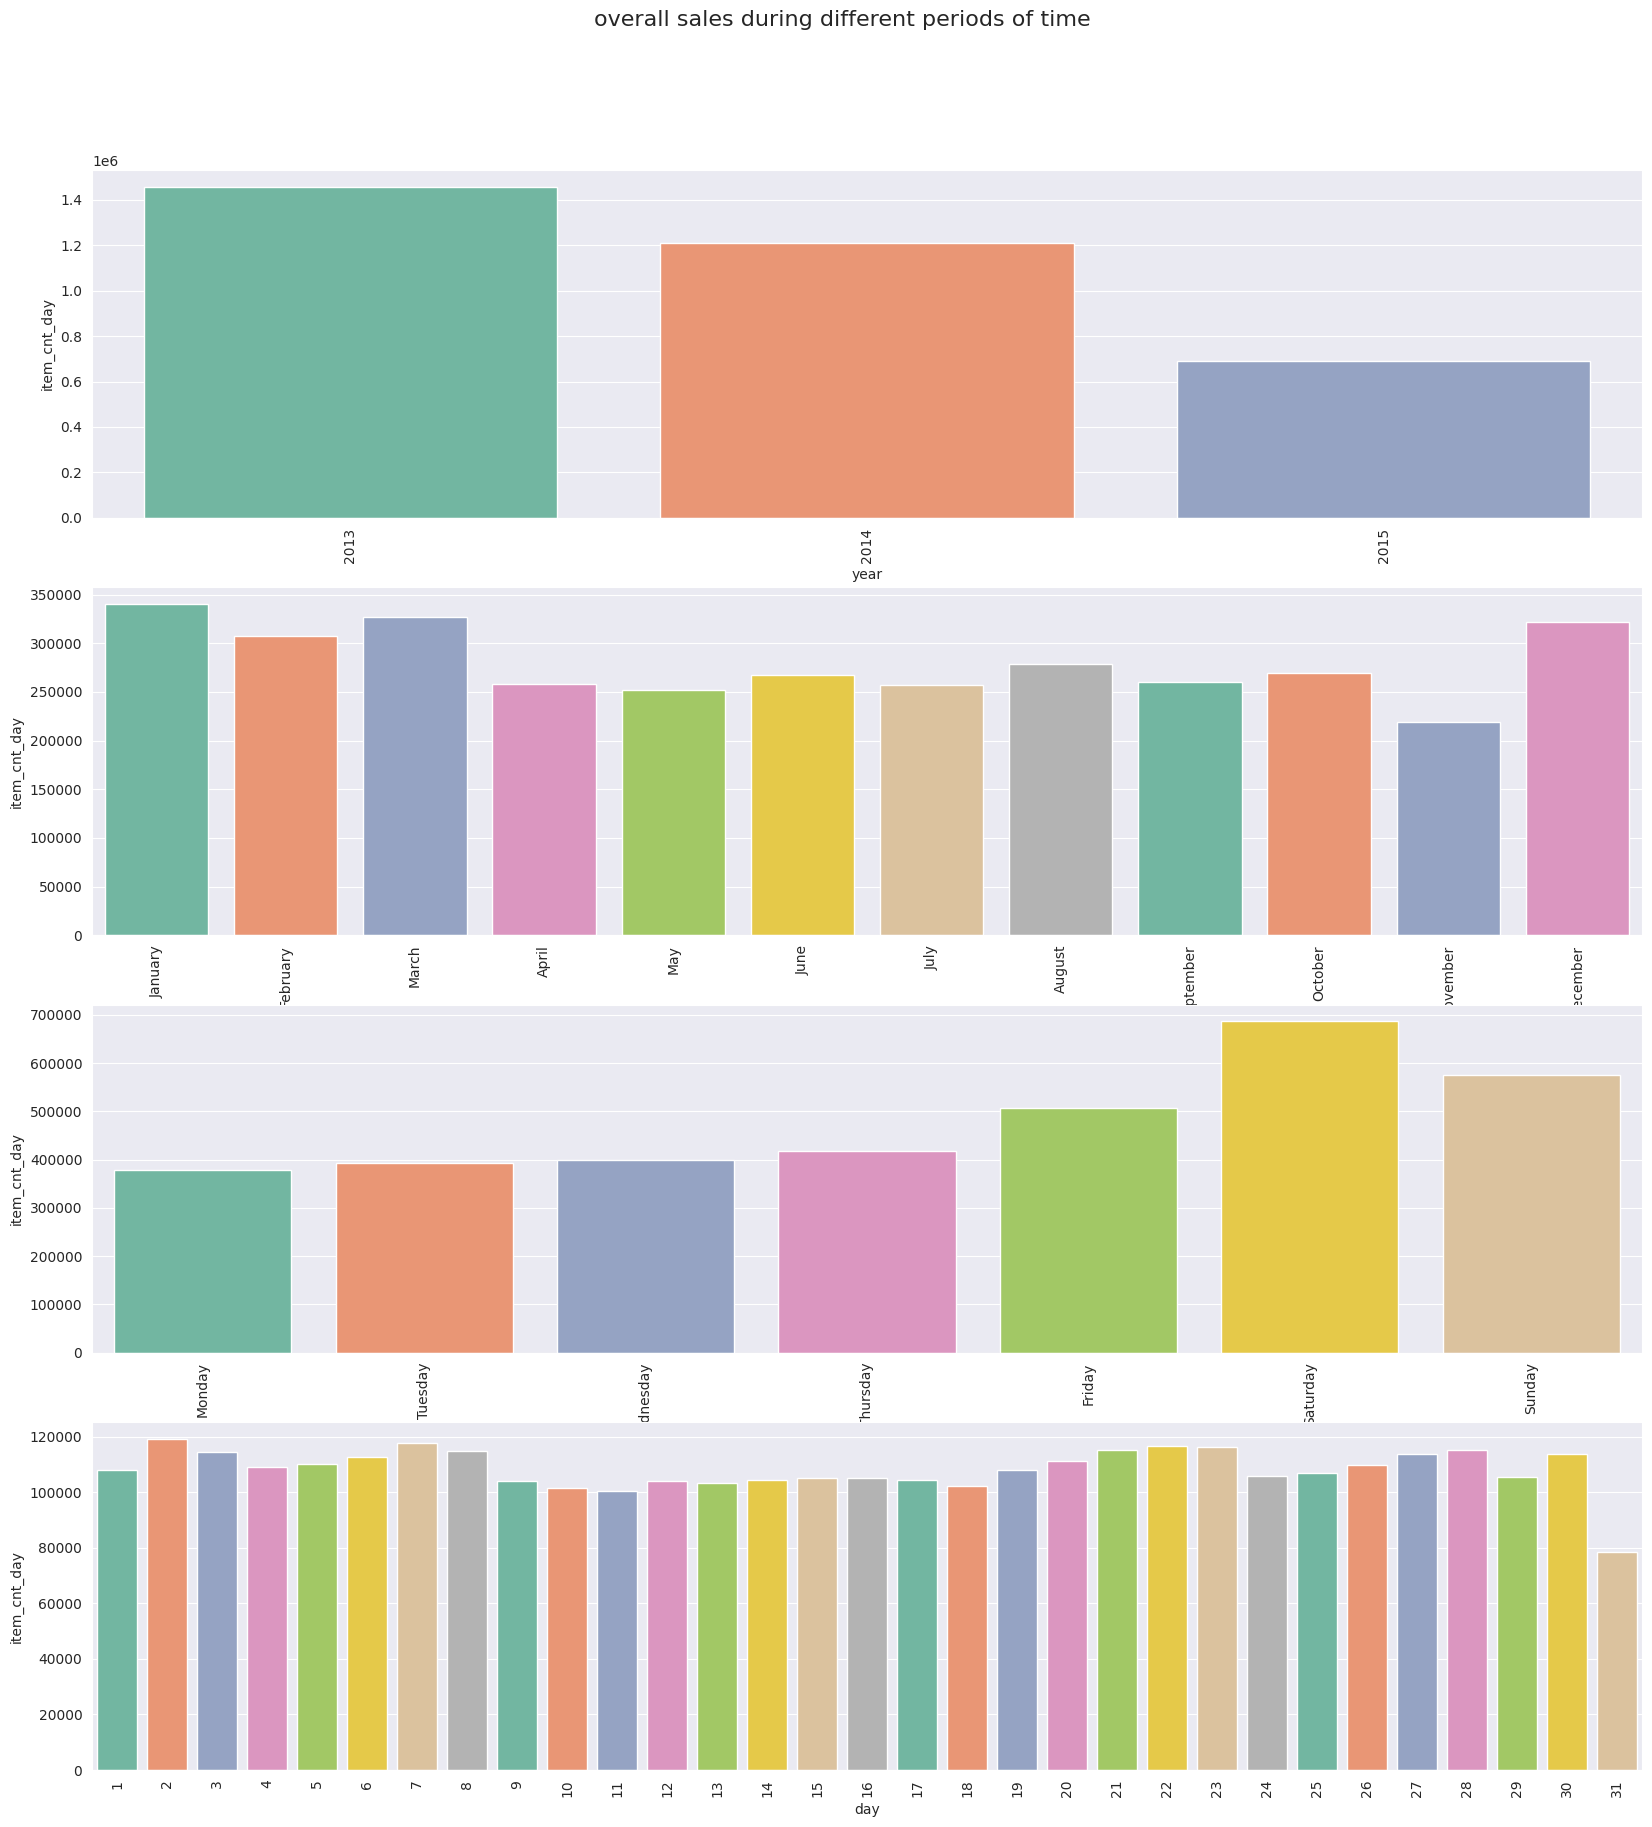

In [9]:
cols = ['year', 'month', 'week_day', 'day']

barplots(data, cols, title='overall sales during different periods of time')

here we can see the reason for sales droppping at months № 3, 15 and 24: the sales are very high in December bc of the new year, then in the next three months they decrease, but there are still some holidays (like the valentine's day and the international women's day) which cause the sales to stay higher than average during those months. after that, there's not that much holidays, so the sales decrease even further.

besides that, these three plots show us the following information:
- as expected, the sales drop over time, we can see the amount of items sold decrease each year. the sales over the last year are approx. twice as low as during the first year
- there's no strong trend of the amount of items sold over the course of one year. however, the sales rise around the new year (and, apparently, in march)
- sales remain approx. the same over the working days, but rise drastically from friday to sunday (esp. on saturday)
- overall sales do not depend on the day of the month (we can see a drop at 31, but that's probably due to the fact that some months have only 30 days)

since this data seems quite significant, it may be a good thing to include those values as input for the future model

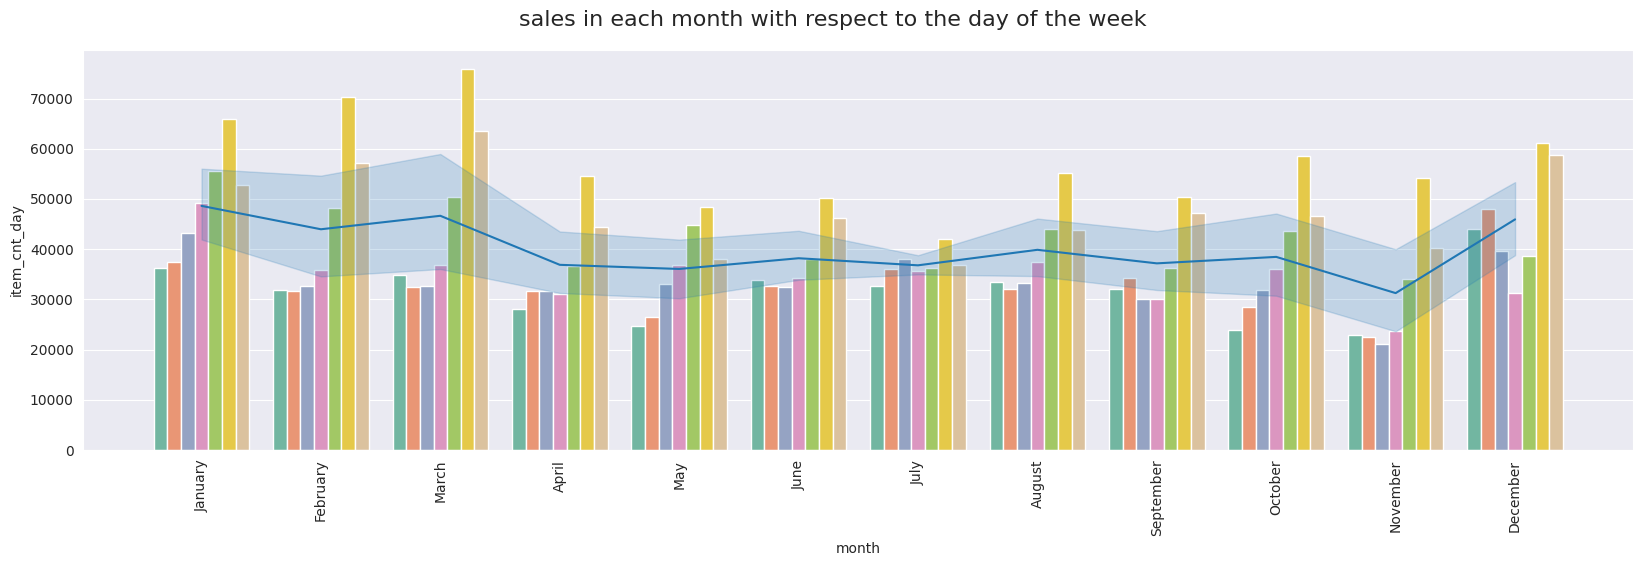

In [10]:
cols = ['month']
# data_to_plot = data[['date', 'shop_id', 'item_cnt_day']].groupby('date').sum()
barplots(df=data, columns=cols, hue='week_day', aggregation='sum', show_line=True, title='sales in each month with respect to the day of the week')

as we may see, for some reason the working day sales remain the same over different months (dropped in November though), but the weekend sales are much higher in Jan, Feb and March.

## time series analysis

In [11]:
target = 'item_cnt_day'
data['detrended'] = detrend(data[target])

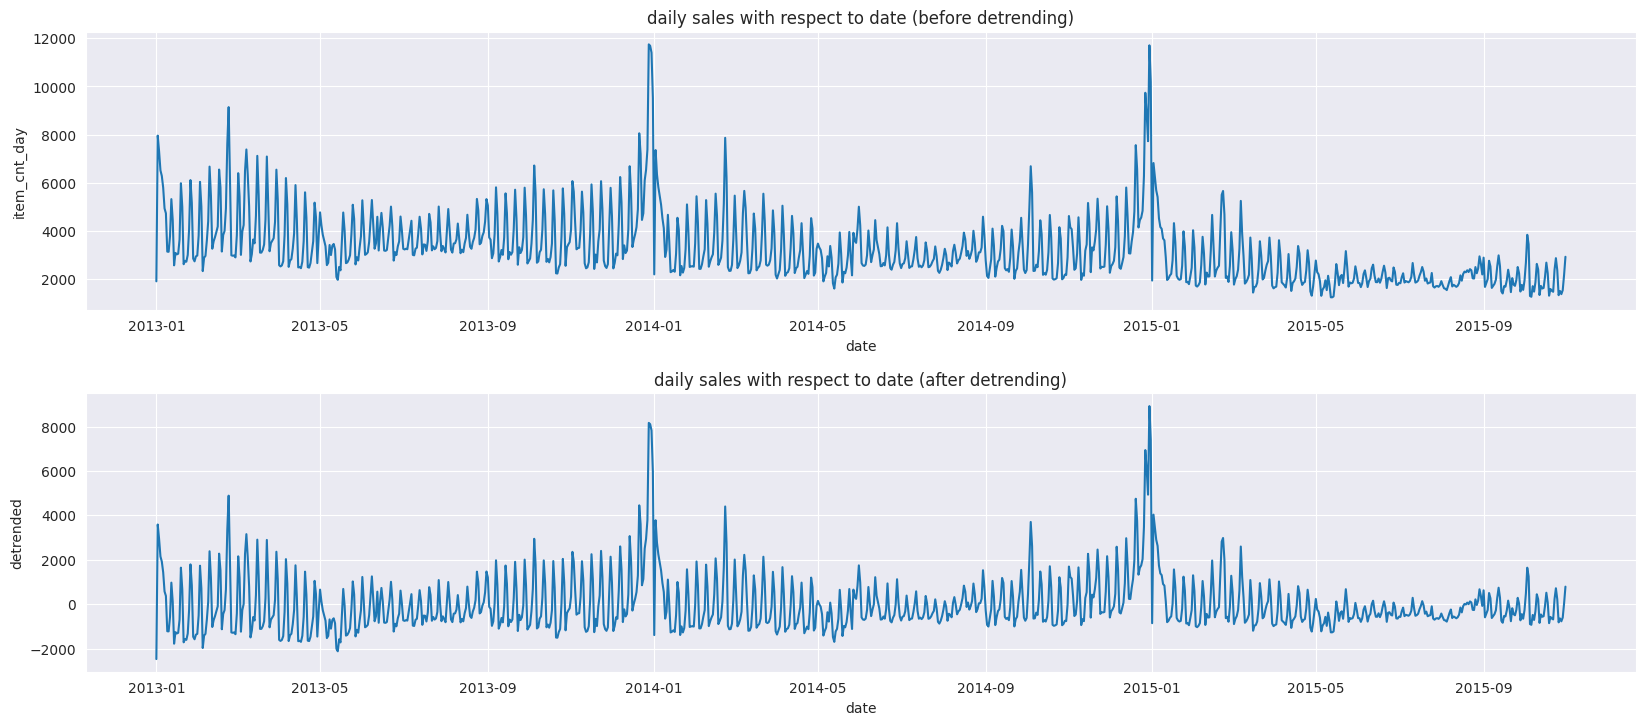

In [12]:
plt.figure(figsize=(20, 8))
plt.subplot(2, 1, 1)
plt.title('daily sales with respect to date (before detrending)')
data_to_plot = data[['date', 'item_cnt_day']].groupby('date').sum()
sns.lineplot(data=data_to_plot, x='date', y='item_cnt_day')
plt.subplot(2, 1, 2)
plt.title('daily sales with respect to date (after detrending)')
data_to_plot['detrended'] = detrend(data_to_plot[target])
sns.lineplot(data=data_to_plot, x='date', y='detrended')
plt.subplots_adjust(bottom=0.1,
                    top=0.9,
                    hspace=0.3)
plt.show()

this plot s mostly used to see how detrending works. on the first plot we can see a slight decrease in sales over time

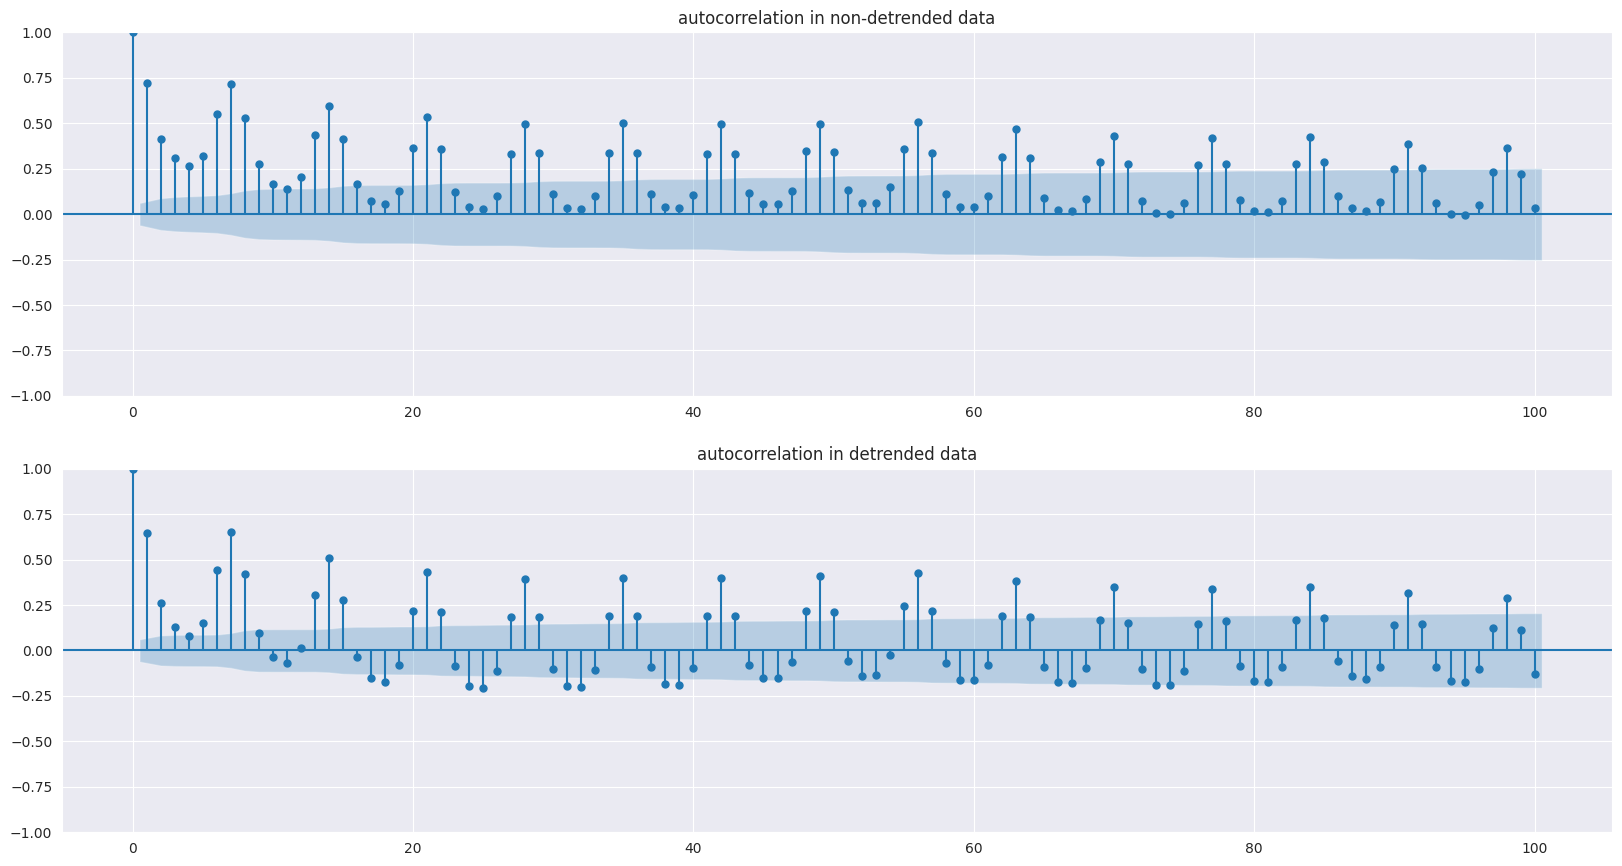

In [13]:
_, ax = plt.subplots(2, 1, figsize=(20, 10))
lags = 100
plot_acf(data_to_plot['item_cnt_day'], ax=ax[0], title='autocorrelation in non-detrended data', lags=lags)
plot_acf(data_to_plot['detrended'], ax=ax[1],
         title='autocorrelation in detrended data', lags=lags)
plt.subplots_adjust(bottom=0.1,
                    top=0.9,
                    hspace=0.2)
plt.show()

we can extract some of those spikes as new features, because they seem to correlate with current values

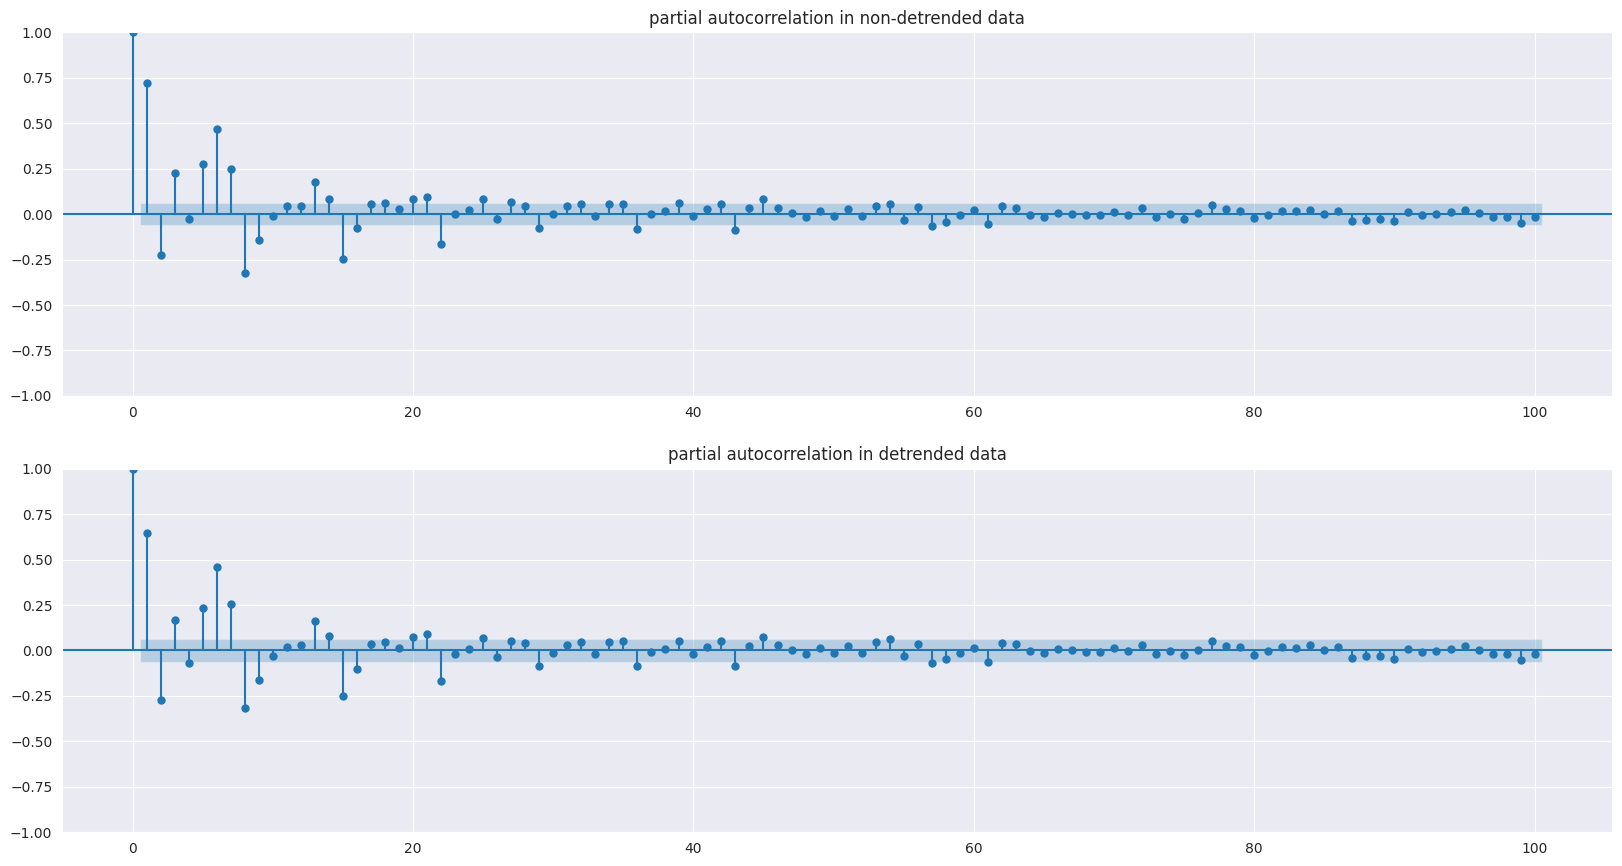

In [16]:
_, ax = plt.subplots(2, 1, figsize=(20, 10))
lags = 100
plot_pacf(data_to_plot['item_cnt_day'], ax=ax[0],
         title='partial autocorrelation in non-detrended data', lags=lags)
plot_pacf(data_to_plot['detrended'], ax=ax[1],
         title='partial autocorrelation in detrended data', lags=lags)
plt.subplots_adjust(bottom=0.1,
                    top=0.9,
                    hspace=0.2)
plt.show()

looking at those plots we can tell that within a range of around 120 days the amount of sales has a statistically significant pattern (that is probably connected with the amount of sales on the weekends, since the period is roughly 7 days).  

## Conclusion

- we can see some time-related patterns in the data (e.g. increased sales on weekends and suring holidays)
- overall amount of sales decreases over time, which leads to the revenue being almost twice as small in 2015 compared to 2013
- some shops and item categories are significantly more popular than the other ones, which makes those features quite important during predictions